In [ ]:
### Authors: 
#### AKASH SAINI (CS21M003)
#### RETURAJ BURNWAL (CS21D406)

In [ ]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

In [ ]:
import numpy as np
from collections import namedtuple, deque
import gym
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import enum

In [ ]:
class Actions(enum.IntEnum):
  SOUTH   = 0
  NORTH   = 1
  EAST    = 2
  WEST    = 3
  PICKUP  = 4
  DROPOFF = 5


class Locations(enum.IntEnum):
  RED    = 0
  GREEN  = 1
  YELLOW = 2
  BLUE   = 3    

In [ ]:
BLOCKED_TRANSITION = {(1, 2), (6, 7), (15, 16), (17, 18), (20, 21), (22, 23)}

LOCATIONS_MAP = {Locations.RED: (0, 0), Locations.GREEN: (0, 4), Locations.YELLOW: (4, 0), Locations.BLUE: (4, 3)}

DIRECTION_MAP = {Actions.SOUTH: (1, 0), Actions.NORTH: (-1, 0), Actions.EAST: (0, 1), Actions.WEST: (0, -1)}

def is_blocked(curr_state, next_state):
  return ((curr_state, next_state) in BLOCKED_TRANSITION) or ((next_state, curr_state) in BLOCKED_TRANSITION)

In [ ]:
class BaseOption(object):
  def is_initiation_state(self, env, state):
    raise NotImplementedError
  
  def get_action(self, env, state):
    raise NotImplementedError

  def is_terminal_state(self, env, state):
    raise NotImplementedError

  def get_option(self, env, state):
    optdone, optaction = False, None
    if self.is_terminal_state(env, state):
      optdone = True
    else:
      optaction = self.get_action(env, state)
    return [optdone, optaction]

In [ ]:
class PrimitiveOption(BaseOption):
  def __init__(self, primitive_action):
    self.t = 0
    self.primitive_action = primitive_action

  def is_initiation_state(self, env, state): # any state is valid for primitive action
      return True

  def get_action(self, env, state):
    self.t += 1
    return self.primitive_action

  def is_terminal_state(self, env, state):  # primitive actions ends in 1 step
    if self.t > 0:
      self.t = 0   # reset t to zero
      return True
    return False


class GotoOption(BaseOption):
  def __init__(self, goto):
    self.goto = goto
    self.destination_pos = LOCATIONS_MAP[self.goto]
    self.rows, self.cols = 5, 5
    self.primitive_actions = self.get_primitive_actions()

  def get_primitive_actions(self):
    n = self.rows*self.cols
    actions = np.zeros(n, dtype=int)
    visited = np.zeros(n, dtype=np.bool_)
    q = deque()
    q.append(self.destination_pos)
    while q:
      size = len(q)
      for i in range(size):
        cx, cy = q.popleft()
        cs = cx*self.cols + cy
        if visited[cs]: continue
        visited[cs] = True
        for a, (xmove, ymove) in DIRECTION_MAP.items():
          nx, ny = cx + xmove, cy + ymove
          ns = nx*self.cols + ny
          if nx<0 or ny<0 or nx>=self.rows or ny>=self.cols or visited[ns] or is_blocked(cs, ns):
            continue
          q.append((nx, ny))
          if a < 2:  # action a car need to take to reach from ns to cs
            actions[ns] = a^1
          else:
            actions[ns] = ((a-2)^1) + 2
    return actions

  def is_initiation_state(self, env, state):  # True for all state except when state is equal to destination
    cx, cy, _, _ = env.decode(state)
    return (cx, cy) != self.destination_pos

  def get_action(self, env, state):
    cx, cy, _, _ = env.decode(state)
    cs = cx*self.cols + cy
    return self.primitive_actions[cs]

  def is_terminal_state(self, env, state):  # here terminal state is inverse of initiation state conditions 
    return not self.is_initiation_state(env, state)

In [ ]:
class BaseHRL(object):
  def __init__(self, env, num_states, options, ep, ep_decay, alpha, gamma=0.9, max_step=1000):
    self.env = env
    self.num_states = num_states
    self.options = options
    self.gamma = gamma
    self.ep = ep
    self.ep_decay = ep_decay
    self.alpha = alpha
    self.max_step = max_step

  def ep_greedy(self, state, Q, ep):
    option = None
    if np.random.rand() > ep:
      option = np.argmax(Q[state])
    else:
      option = np.random.randint(len(self.options))
    return option

  def execute_option(self, env, state, option_indx, Q, Q_update_freq):
    raise NotImplementedError

  def run_episodes(self, episodes):
    env = self.env
    Q = np.zeros((self.num_states, len(self.options)))
    Q_update_freq = np.zeros((self.num_states, len(self.options)))
    episode_rewards, episode_steps = np.zeros(episodes), np.zeros(episodes)
    ep = self.ep
    for episode in range(episodes):
      state, done = env.reset(), False
      ep = max(ep*self.ep_decay, 0.01)
      while (not done) and (episode_steps[episode] < self.max_step):
        option_indx = self.ep_greedy(state, Q, ep)
        state, done, rewards, steps = self.execute_option(env, state, option_indx, Q, Q_update_freq)
        episode_steps[episode] += steps
        episode_rewards[episode] += rewards
    return Q, Q_update_freq, episode_rewards, episode_steps

  def avg_run(self, runs=10, episodes=100):
    avg_Q = np.zeros((self.num_states, len(self.options)))
    avg_Q_update_freq = np.zeros((self.num_states, len(self.options)))
    avg_rewards, avg_steps = np.zeros(episodes), np.zeros(episodes)
    for run in range(runs):
      Q, Q_update_freq, rewards, steps = self.run_episodes(episodes)
      avg_Q += (Q - avg_Q) / (run + 1)
      avg_Q_update_freq += (Q_update_freq - avg_Q_update_freq) / (run + 1)
      avg_rewards += (rewards - avg_rewards) / (run + 1)
      avg_steps += (steps - avg_steps) / (run + 1)
    return avg_Q, avg_Q_update_freq, avg_rewards, avg_steps

In [ ]:
class SMDP(BaseHRL):
  def __init__(self, env, num_states, options, ep=1.0, ep_decay=0.9, alpha=0.1):
    super().__init__(env, num_states, options, ep=ep, ep_decay=ep_decay, alpha=alpha)

  def execute_option(self, env, state, option_indx, Q, Q_update_freq):
    next_state, done, total_reward, steps = state, False, 0, 0
    option = self.options[option_indx]
    if not option.is_initiation_state(env, state):
      Q[state, option_indx] = -20  # to discourage epsilon greedy from choosing this option in this state.
      return next_state, done, total_reward, steps
    r_bar, g = 0, 1
    optdone, optaction = option.get_option(env, state)
    while not optdone:
      next_state, reward, done, _ = env.step(optaction)
      r_bar += g*reward
      g *= self.gamma
      total_reward += reward
      steps += 1
      optdone, optaction = option.get_option(env, next_state)
    Q[state, option_indx] += self.alpha * (r_bar + g*np.max(Q[next_state]) - Q[state, option_indx])
    Q_update_freq[state, option_indx] += 1
    return next_state, done, total_reward, steps


class IntraQ(BaseHRL): 
  def __init__(self, env, num_states, options, ep=1.0, ep_decay=0.9, alpha=0.1):
    super().__init__(env, num_states, options, ep=ep, ep_decay=ep_decay, alpha=alpha)
    self.queue = deque()

  def execute_option(self, env, state, option_indx, Q, Q_update_freq):
    next_state, done, total_reward, steps = state, False, 0, 0
    option = self.options[option_indx]
    if not option.is_initiation_state(env, state):
      Q[state, option_indx] = -20  # to discourage epsilon greedy from choosing this option in this state.
      return next_state, done, total_reward, steps
    optdone, optaction = option.get_option(env, state)
    assert not optdone, f"Option should terminated before starting for {list(env.decode(state))} {option_indx}"
    while not optdone: # Incomplete IntraQ code (Please carefully read the algorithm)
      state = next_state
      next_state, reward, done, _ = env.step(optaction)
      total_reward += reward
      steps += 1
      optdone, optaction = option.get_option(env, next_state)
      self.queue.append((state, option_indx))
      if not optdone:
        Q[state, option_indx] += self.alpha * (reward + self.gamma*Q[next_state, option_indx] - Q[state, option_indx])
    Q[state, option_indx] += self.alpha * (reward + self.gamma*np.max(Q[next_state]) - Q[state, option_indx])
    expected_update_cnt = 1 / len(self.queue)
    while self.queue:
      s, a = self.queue.popleft()
      Q_update_freq[s, a] += expected_update_cnt
    assert not self.queue
    return next_state, done, total_reward, steps

In [ ]:
env = gym.make('Taxi-v3')
env.seed(0)
np.random.seed(0)

episodes = 2000

num_states = env.observation_space.n

options = []
for primitive_action in Actions:
  options.append(PrimitiveOption(primitive_action))
for goto_loc in Locations:
  options.append(GotoOption(goto_loc))

### SMDP Q Learning

In [ ]:
smdp = SMDP(env, num_states, options)
s_avg_Q, s_avg_Q_update_freq, s_avg_rewards, s_avg_steps = smdp.avg_run(runs=10, episodes=episodes)

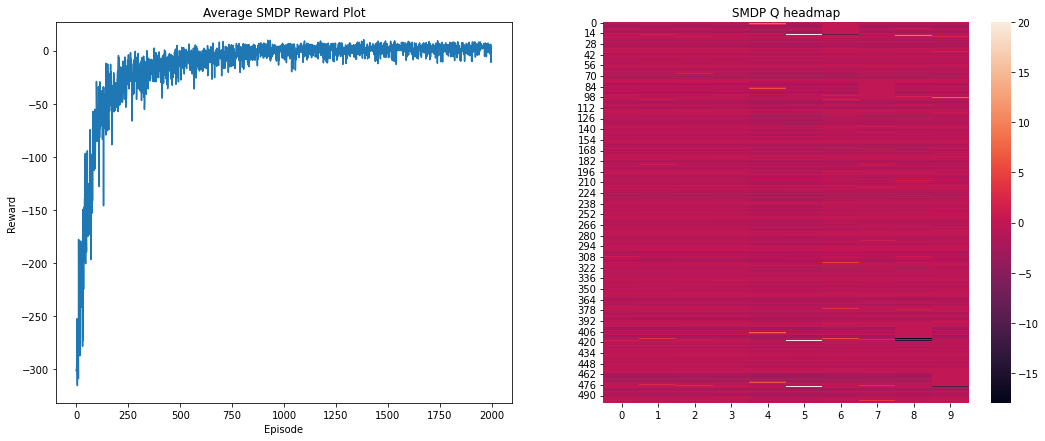

In [ ]:
plt.figure(figsize=(18,7))

plt.subplot(1, 2, 1)
plt.title("Average SMDP Reward Plot")
plt.ylabel("Reward")
plt.xlabel("Episode")
plt.plot(np.arange(episodes), s_avg_rewards)

plt.subplot(1, 2, 2)
ax = sns.heatmap(s_avg_Q)
ax.set_title("SMDP Q headmap")

plt.show()


### Intra Q Learning

In [ ]:
intraq = IntraQ(env, num_states, options)
i_avg_Q, i_avg_Q_update_freq, i_avg_rewards, i_avg_steps = intraq.avg_run(runs=10, episodes=episodes)

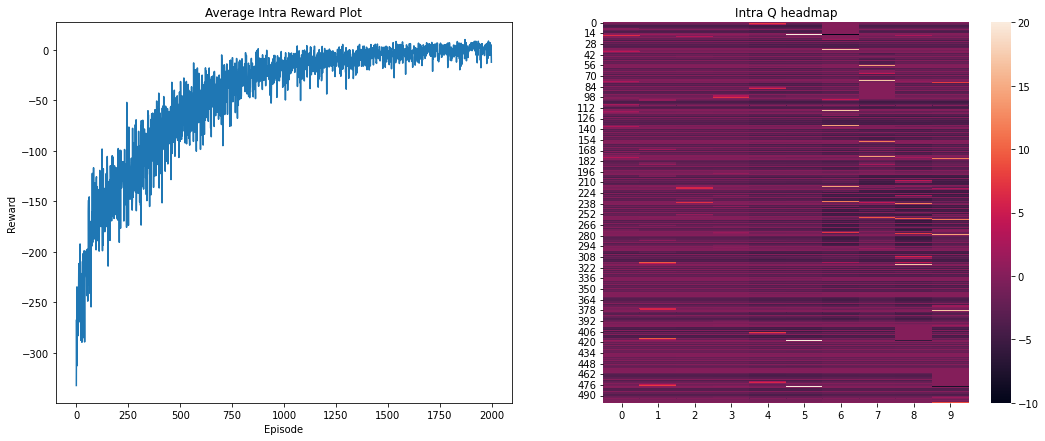

In [ ]:
plt.figure(figsize=(18,7))

plt.subplot(1, 2, 1)
plt.title("Average Intra Reward Plot")
plt.ylabel("Reward")
plt.xlabel("Episode")
plt.plot(np.arange(episodes), i_avg_rewards)

plt.subplot(1, 2, 2)
ax = sns.heatmap(i_avg_Q)
ax.set_title("Intra Q headmap")

plt.show()

### Compare SMDP and Intra-Option Q-Learning

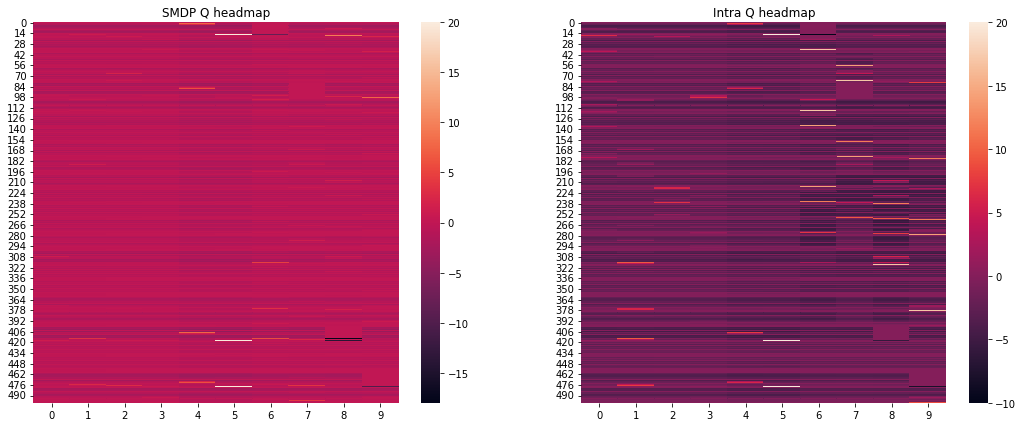

In [ ]:
plt.figure(figsize=(18,7))

plt.subplot(1, 2, 1)
ax = sns.heatmap(s_avg_Q)
ax.set_title("SMDP Q headmap")

plt.subplot(1, 2, 2)
ax = sns.heatmap(i_avg_Q)
ax.set_title("Intra Q headmap")
plt.show()

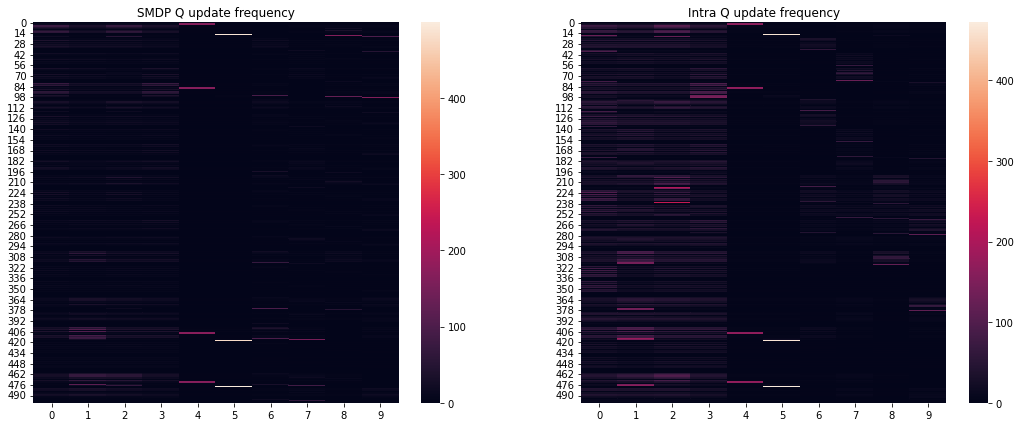

In [ ]:
plt.figure(figsize=(18,7))

plt.subplot(1, 2, 1)
ax = sns.heatmap(s_avg_Q_update_freq)
ax.set_title("SMDP Q update frequency")

plt.subplot(1, 2, 2)
ax = sns.heatmap(i_avg_Q_update_freq)
ax.set_title("Intra Q update frequency")
plt.show()

### Alternet Set of Options

In [ ]:
class GoAndDropOrPickOption(GotoOption):
  def __init__(self, goto, drop_or_pick_action):
    super().__init__(goto)
    self.drop_or_pick_action = drop_or_pick_action
    self.done = False

  def is_initiation_state(self, env, state): # any state is valid for this option
    return True

  def get_action(self, env, state):
    cx, cy, _, _ = env.decode(state)
    if (cx, cy) == self.destination_pos:   # Once agent reaches the destination position it executes dropoff
      self.done = True
      return self.drop_or_pick_action
    return super().get_action(env, state)
  
  def is_terminal_state(self, env, state):
    if self.done:
      self.done = False  # reset done flag
      return True
    return False

In [ ]:
env = gym.make('Taxi-v3')
env.seed(0)
np.random.seed(0)

episodes = 2000

num_states = env.observation_space.n

alternate_options = []
for goto_loc in Locations:
  for drop_or_pick in [Actions.DROPOFF, Actions.PICKUP]:
    alternate_options.append(GoAndDropOrPickOption(goto_loc, drop_or_pick))

### SMDP Q Learning

In [ ]:
a_smdp = SMDP(env, num_states, alternate_options)
a_s_avg_Q, a_s_avg_Q_update_freq, a_s_avg_rewards, a_s_avg_steps = a_smdp.avg_run(runs=10, episodes=episodes)

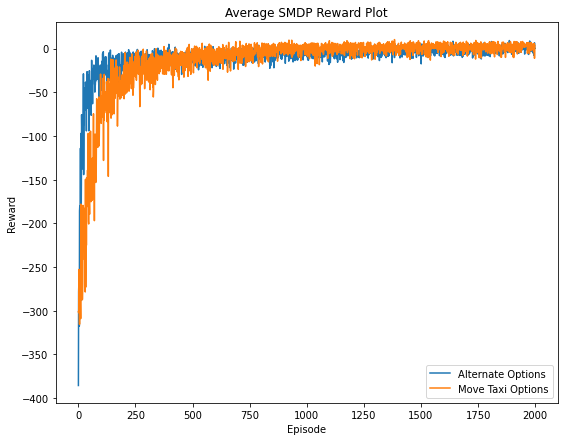

In [ ]:
a_s_avg_Q[a_s_avg_Q <= -20] = 0


plt.figure(figsize=(9,7))

plt.title("Average SMDP Reward Plot")
plt.ylabel("Reward")
plt.xlabel("Episode")
plt.plot(np.arange(episodes), a_s_avg_rewards, label="Alternate Options")
plt.plot(np.arange(episodes), s_avg_rewards, label="Move Taxi Options")
plt.legend()

plt.show()

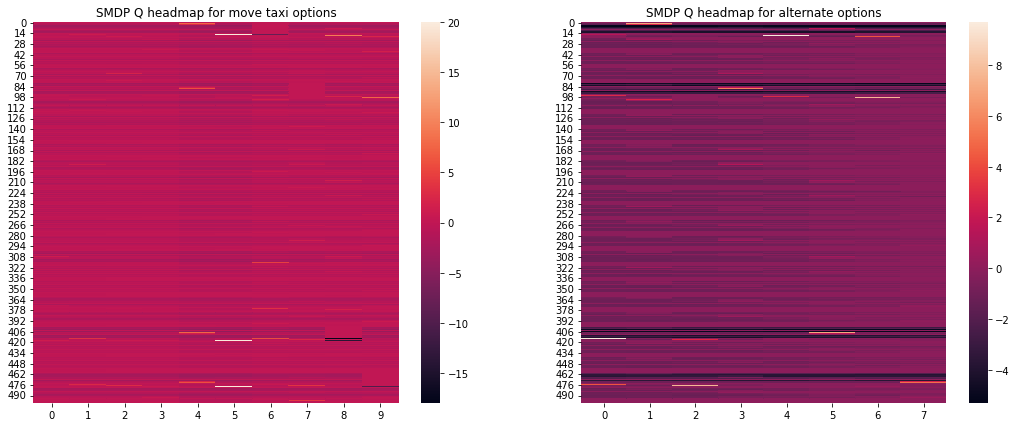

In [ ]:
plt.figure(figsize=(18,7))

plt.subplot(1, 2, 1)
ax = sns.heatmap(s_avg_Q)
ax.set_title("SMDP Q headmap for move taxi options")

plt.subplot(1, 2, 2)
ax = sns.heatmap(a_s_avg_Q)
ax.set_title("SMDP Q headmap for alternate options")

plt.show()

### Intra Q Learning

In [ ]:
a_intraq = IntraQ(env, num_states, alternate_options)
a_i_avg_Q, a_i_avg_Q_update_freq, a_i_avg_rewards, a_i_avg_steps = a_intraq.avg_run(runs=10, episodes=episodes)

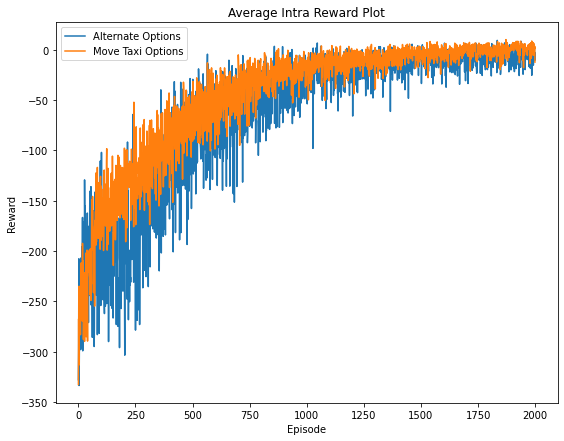

In [ ]:
a_i_avg_Q[a_i_avg_Q <= -20] = 0


plt.figure(figsize=(9,7))

plt.title("Average Intra Reward Plot")
plt.ylabel("Reward")
plt.xlabel("Episode")
plt.plot(np.arange(episodes), a_i_avg_rewards, label="Alternate Options")
plt.plot(np.arange(episodes), i_avg_rewards, label="Move Taxi Options")
plt.legend()

plt.show()

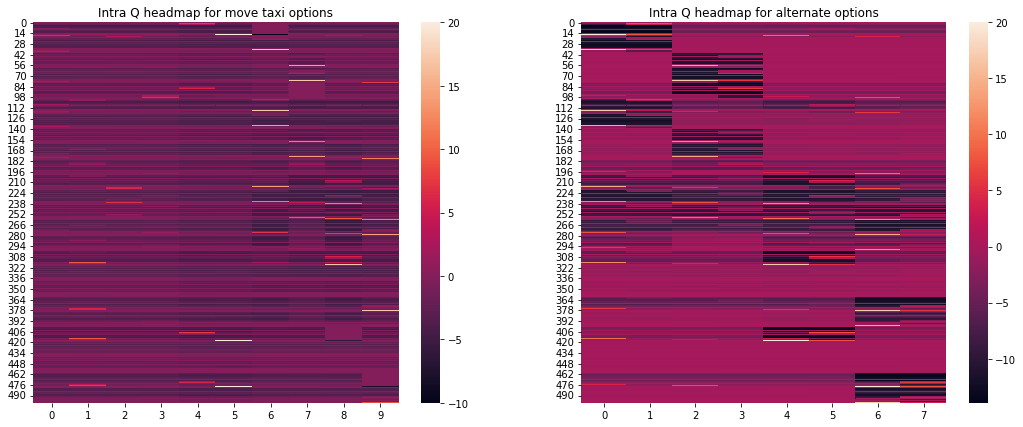

In [ ]:
plt.figure(figsize=(18,7))

plt.subplot(1, 2, 1)
ax = sns.heatmap(i_avg_Q)
ax.set_title("Intra Q headmap for move taxi options")

plt.subplot(1, 2, 2)
ax = sns.heatmap(a_i_avg_Q)
ax.set_title("Intra Q headmap for alternate options")

plt.show()